In [8]:
import datetime
import requests
import pandas as pd


time = datetime.datetime(2024,10,1,0,0).timestamp()
# Define the API endpoint and parameters
url = 'https://api.binance.com/api/v3/klines'
params = {
    'symbol': 'ETHUSDT',  # Replace with the desired trading pair
    'interval': '1h',     # Options: 1m, 3m, 5m, etc.
    # 'startTime' : 1725455241,
    # 'endTime' : '',
    'limit': 1000
}
# https://developers.binance.com/docs/binance-spot-api-docs/rest-api#klinecandlestick-data

# Make the HTTP GET request
response = requests.get(url, params=params)
data = response.json()

# Check for errors
if response.status_code != 200:
    print(f"Error fetching data: {data['msg']}")
    exit()

# Create a DataFrame and assign column names
columns = [
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'
]
df = pd.DataFrame(data, columns=columns)

# Convert timestamps to datetime
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')

# Convert numeric columns to appropriate data types
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'Quote asset volume', 'Taker buy base asset volume',
                   'Taker buy quote asset volume']
df[numeric_columns] = df[numeric_columns].astype(float)

# Display the DataFrame
print(df.head(2))
df.info()


            Open time     Open     High      Low    Close     Volume  \
0 2024-08-24 00:00:00  2762.49  2769.60  2752.20  2757.93  8638.2855   
1 2024-08-24 01:00:00  2757.93  2758.22  2742.47  2753.13  8834.7931   

               Close time  Quote asset volume  Number of trades  \
0 2024-08-24 00:59:59.999        2.384398e+07             50144   
1 2024-08-24 01:59:59.999        2.429262e+07             47463   

   Taker buy base asset volume  Taker buy quote asset volume Ignore  
0                    4240.5597                  1.170667e+07      0  
1                    4326.4448                  1.189580e+07      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Open time                     1000 non-null   datetime64[ns]
 1   Open                          1000 non-null   float64       
 

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                   'Quote asset volume', 'Taker buy base asset volume',
                   'Taker buy quote asset volume']
df[numeric_columns] = df[numeric_columns].astype(float)
df = df.sort_values('Open time')


# Prepare the data
features = ['Open', 'Close', 'Volume']
data = df[features]

# Initialize separate scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Fit the scalers
scaled_data_X = scaler_X.fit_transform(data)
scaled_data_y = scaler_y.fit_transform(data[['Close']])  # Target is 'Close' price

sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data_X)):
    X.append(scaled_data_X[i - sequence_length:i])
    y.append(scaled_data_y[i, 0])  # Target is 'Close' price

X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

training_size = int(len(X) * 0.8)

X_train = X[:training_size]
y_train = y[:training_size]
X_test = X[training_size:]
y_test = y[training_size:]


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

In [33]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values using scaler_y
y_pred_scaled = scaler_y.inverse_transform(y_pred)
y_test_scaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#  Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 18.30810216723426
Mean Absolute Error: 13.018416046791877


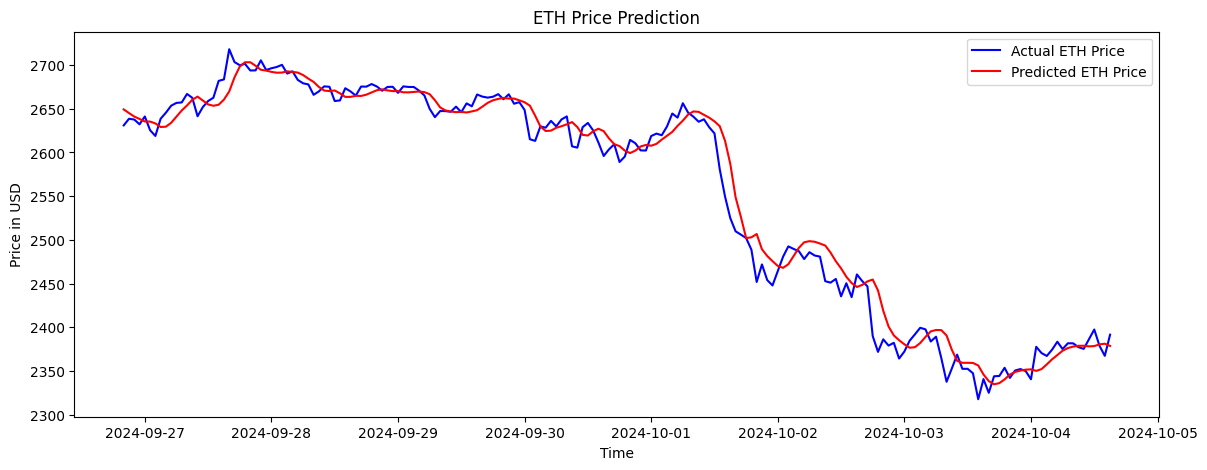

In [36]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14,5))
plt.plot(df['Open time'][len(df) - len(y_test_scaled):], y_test_scaled, color='blue', label='Actual ETH Price')
plt.plot(df['Open time'][len(df) - len(y_test_scaled):], y_pred_scaled, color='red', label='Predicted ETH Price')
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

In [42]:
# 1. Prepare the latest input sequence
latest_data = data[-sequence_length:]

# Scale the latest data using 'scaler_X'
latest_data_scaled = scaler_X.transform(latest_data)

# Create the input sequence
X_new = []
X_new.append(latest_data_scaled)

# Convert to numpy array and reshape
X_new = np.array(X_new)
# Shape should be (samples, time steps, features)
print("Input shape for prediction:", X_new.shape)

# 2. Make the prediction
y_next_scaled = model.predict(X_new)

# Inverse transform the prediction using 'scaler_y'
y_next = scaler_y.inverse_transform(y_next_scaled)

# Extract the predicted price
predicted_price = y_next[0][0]

# Get the timestamp of the last data point
last_timestamp = df['Open time'].iloc[3]
last_timestamp = 1727740800

# Calculate the next timestamp (since data is hourly)
next_timestamp = last_timestamp + 316940

print(df.iloc[-1])

# 4. Print the forecasted price with timestamp
print(f"The forecasted ETH price for is: ${predicted_price:.2f}")


Input shape for prediction: (1, 60, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Open time                              2024-10-04 15:00:00
Open                                               2367.21
High                                                2395.4
Low                                                2366.95
Close                                              2391.43
Volume                                           8013.6065
Close time                      2024-10-04 15:59:59.999000
Quote asset volume                         19127024.734194
Number of trades                                     59735
Taker buy base asset volume                      5159.8508
Taker buy quote asset volume               12314832.634044
Ignore                                                   0
Name: 999, dtype: object
The forecasted ETH price for is: $2379.49
